In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [2]:
df_stations = pd.read_csv('./tankerkoenig-data/stations/stations.csv')

In [3]:
df_stations.name = df_stations.name.str.lower()
df_stations.name = df_stations.name.str.replace(' ','_')

nan_stations = df_stations[df_stations.brand.isna()]
bft_index = nan_stations[nan_stations.name.str.contains('bft')].index
df_stations.iloc[bft_index,2] = 'bft'

df_stations.brand = df_stations.brand.str.lower()
df_stations.brand = df_stations.brand.str.replace(' ','_')

nan_stations = df_stations[df_stations.brand.isna()]
bft_index = nan_stations[nan_stations.name.str.contains('bft')].index
df_stations.iloc[bft_index,2] = 'bft'

In [4]:
top_20 = df_stations.brand.value_counts()[0:30].index.to_list()
df_stations.loc[df_stations[~df_stations.brand.isin(top_20)].index, 'brand'] = 'other'

## Reduce number of brands and convert them to dummies

In [5]:
# Set all station not in the top 5 to others
df_stations.loc[df_stations.brand.isin(list(df_stations.brand.value_counts()[5:].index)), 'brand'] = 'other'

In [6]:
df_stations.brand.value_counts()

other    9284
aral     2378
shell    1821
esso     1066
total     893
Name: brand, dtype: int64

In [7]:
dummies = pd.get_dummies(df_stations.brand, drop_first=True)

In [8]:
df_stations = df_stations.join(dummies)

In [9]:
df_stations.drop(columns='brand', inplace=True)

In [10]:
df_stations.head()

,uuid,name,street,house_number,post_code,city,latitude,longitude,esso,other,shell,total
0,00060723-0001-4444-8888-acdc00000001,bageno_raiffeisen_eg,Künzelsauer Strasse,7,74653,Ingelfingen,49.296822,9.661385,0,1,0,0
1,005056ba-7cb6-1ed2-bceb-5332ab168d12,famila_tankstelle,Pascalstrasse,9,25442,Quickborn,53.742150,9.941240,0,1,0,0
2,005056ba-7cb6-1ed2-bceb-573c18314d16,star_tankstelle,Riehler Strasse,240,50735,Köln,50.961800,6.980070,0,1,0,0
3,005056ba-7cb6-1ed2-bceb-662ba1a94d1f,star_tankstelle,BAB 10 / Seeberg Ost,NaN,15345,Altlandsberg,52.550160,13.682120,0,1,0,0
4,005056ba-7cb6-1ed2-bceb-6f7b23564d23,star_tankstelle,Duisburger Straße,130,47166,Duisburg,51.489790,6.783730,0,1,0,0


In [11]:
df_stations.to_pickle('./data/df_stations_cleaned.pkl')

## Produce time series 

In [12]:
df = pd.read_pickle("./data/df_FULL_365.pkl", compression='xz')

In [13]:
df.date = pd.to_datetime(df.date, utc=True).dt.tz_convert('Europe/Berlin')

In [14]:
df_test = df[(df.date > pd.to_datetime('2019-10-01').tz_localize('Europe/Berlin'))]

In [15]:
df_test

,date,station_uuid,diesel,e5,e10,dieselchange,e5change,e10change
0,2019-10-01 00:00:04+02:00,13f091dc-3019-4c30-ad84-7e7065b81f0c,1.269,1.409,1.389,1,1,1
1,2019-10-01 00:01:05+02:00,33d43a63-5589-4ee6-88b5-7d5093751fe5,1.209,1.349,1.329,1,1,1
2,2019-10-01 00:01:05+02:00,accbbcb0-bd05-42c8-b0e3-14bce7b0906d,1.239,1.409,1.389,0,1,1
3,2019-10-01 00:01:05+02:00,10dbb42c-f2bb-5985-9dad-fbce82794a46,1.199,1.339,1.319,1,1,1
4,2019-10-01 00:01:05+02:00,e83a5931-55d2-5db2-b6d5-8e595d7f99c0,1.219,0.000,0.000,1,0,0
...,...,...,...,...,...,...,...,...
261476,2019-11-08 23:57:05+01:00,87ac5c03-273a-4b5c-8caa-a9a74c2ff3f0,1.269,1.369,1.349,1,1,1
261477,2019-11-08 23:58:04+01:00,f5a8eaa0-8ee8-46ae-ad1d-0927c1da81c7,1.208,1.378,1.358,1,1,1
261478,2019-11-08 23:59:04+01:00,971984d4-c834-4dad-973e-6b60be6f7bef,1.229,1.379,1.359,1,1,1
261479,2019-11-08 23:59:04+01:00,1a5e5bc5-2a69-48d6-bdf2-185c00b9196e,1.219,1.389,1.369,1,0,0


In [16]:
def ts_calculation(group):
    min_diesel = min(group.diesel)
    max_diesel = max(group.diesel)
    mean_diesel = np.mean(group.diesel)
    return min_diesel, max_diesel, mean_diesel

out = df_test.groupby('station_uuid').apply(ts_calculation)

In [17]:
df_ts = pd.DataFrame.from_items(zip(out.index, out.values)).T

/Users/gabriel/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  """Entry point for launching an IPython kernel.


In [18]:
df_ts.columns = ['min_diesel','max_diesel', 'mean_diesel']

In [19]:
df_ts

,min_diesel,max_diesel,mean_diesel
00006210-0037-4444-8888-acdc00006210,1.209,1.339,1.258110
00016899-3247-4444-8888-acdc00000007,1.219,1.389,1.262609
00041414-208c-4444-8888-acdc00000414,1.209,1.259,1.235829
00041450-0002-4444-8888-acdc00000002,1.198,1.238,1.212286
00047369-0001-4444-8888-acdc00000001,0.000,1.259,1.201707
...,...,...,...
fff05f62-7e1e-42e4-8d71-6e2c9c963a8b,1.519,1.549,1.530667
fff2435f-84de-4f41-b62b-9f6810169f45,1.169,1.329,1.246097
fff261ef-ff00-4d2b-8669-ec2f7c57cd93,1.169,1.379,1.233844
fffb0617-e77d-48dd-838c-f43a945f6f70,1.169,1.379,1.249486


In [20]:
df_features = pd.read_pickle('./data/clustering_data.pkl')

In [21]:
df_features = df_features.join(df_ts, rsuffix='_short_timed')
df_features

,changes_diesel,changes_e5,changes_e10,skewness_diesel,skewness_e5,skewness_e10,kurtosis_diesel,kurtosis_e5,kurtosis_e10,var_diesel,...,neighbors_3km,neighbors_5km,kmeans_cluster,brand,isAral,isShell,gmm_cluster,min_diesel_short_timed,max_diesel_short_timed,mean_diesel_short_timed
00006210-0037-4444-8888-acdc00006210,4705.0,4803.0,4774.0,-1.817817,-3.146691,-3.072491,62.660141,61.539534,59.597531,0.004990,...,4.0,5.0,2,beducker,0,0,3,1.209,1.339,1.258110
00016899-3247-4444-8888-acdc00000007,2871.0,2784.0,2788.0,1.714685,0.334382,0.333061,4.012224,-0.197960,-0.203483,0.003830,...,0.0,3.0,1,bft_pickelmann,0,0,1,1.219,1.389,1.262609
00041414-208c-4444-8888-acdc00000414,419.0,430.0,0.0,-6.888683,-6.175341,0.000000,58.131150,39.550679,-3.000000,0.020105,...,7.0,14.0,3,NaN,0,0,2,1.209,1.259,1.235829
00041450-0002-4444-8888-acdc00000002,180.0,176.0,181.0,1.835378,0.306207,-6.659782,2.587737,-0.672192,72.044662,0.004862,...,2.0,16.0,1,NaN,0,0,0,1.198,1.238,1.212286
00047369-0001-4444-8888-acdc00000001,371.0,440.0,438.0,-8.004936,-5.534799,-5.514452,84.381312,33.474356,33.308699,0.014608,...,6.0,7.0,2,NaN,0,0,3,0.000,1.259,1.201707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fff05f62-7e1e-42e4-8d71-6e2c9c963a8b,2834.0,2577.0,2577.0,0.440446,-0.013002,-0.013002,-0.270087,-1.283175,-1.283175,0.004661,...,2.0,2.0,1,total,0,0,0,1.519,1.549,1.530667
fff2435f-84de-4f41-b62b-9f6810169f45,1889.0,1985.0,0.0,0.861832,0.195566,0.000000,1.503967,-0.769527,-3.000000,0.002882,...,0.0,3.0,3,freie_tankstelle,0,0,2,1.169,1.329,1.246097
fff261ef-ff00-4d2b-8669-ec2f7c57cd93,5486.0,5303.0,5303.0,0.922845,0.034749,0.034002,0.671088,-1.113226,-1.114091,0.003059,...,1.0,2.0,0,avia,0,0,1,1.169,1.379,1.233844
fffb0617-e77d-48dd-838c-f43a945f6f70,6723.0,6696.0,6696.0,0.987645,0.244564,0.244564,1.061596,-0.551191,-0.551191,0.003653,...,8.0,12.0,0,westfalen,0,0,1,1.169,1.379,1.249486


In [22]:
mean_diesel = np.mean(df_features.mean_diesel_short_timed)
df_features['relative_mean'] = df_features.mean_diesel_short_timed - mean_diesel
df_features

,changes_diesel,changes_e5,changes_e10,skewness_diesel,skewness_e5,skewness_e10,kurtosis_diesel,kurtosis_e5,kurtosis_e10,var_diesel,...,neighbors_5km,kmeans_cluster,brand,isAral,isShell,gmm_cluster,min_diesel_short_timed,max_diesel_short_timed,mean_diesel_short_timed,relative_mean
00006210-0037-4444-8888-acdc00006210,4705.0,4803.0,4774.0,-1.817817,-3.146691,-3.072491,62.660141,61.539534,59.597531,0.004990,...,5.0,2,beducker,0,0,3,1.209,1.339,1.258110,-0.005177
00016899-3247-4444-8888-acdc00000007,2871.0,2784.0,2788.0,1.714685,0.334382,0.333061,4.012224,-0.197960,-0.203483,0.003830,...,3.0,1,bft_pickelmann,0,0,1,1.219,1.389,1.262609,-0.000678
00041414-208c-4444-8888-acdc00000414,419.0,430.0,0.0,-6.888683,-6.175341,0.000000,58.131150,39.550679,-3.000000,0.020105,...,14.0,3,NaN,0,0,2,1.209,1.259,1.235829,-0.027457
00041450-0002-4444-8888-acdc00000002,180.0,176.0,181.0,1.835378,0.306207,-6.659782,2.587737,-0.672192,72.044662,0.004862,...,16.0,1,NaN,0,0,0,1.198,1.238,1.212286,-0.051001
00047369-0001-4444-8888-acdc00000001,371.0,440.0,438.0,-8.004936,-5.534799,-5.514452,84.381312,33.474356,33.308699,0.014608,...,7.0,2,NaN,0,0,3,0.000,1.259,1.201707,-0.061579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fff05f62-7e1e-42e4-8d71-6e2c9c963a8b,2834.0,2577.0,2577.0,0.440446,-0.013002,-0.013002,-0.270087,-1.283175,-1.283175,0.004661,...,2.0,1,total,0,0,0,1.519,1.549,1.530667,0.267380
fff2435f-84de-4f41-b62b-9f6810169f45,1889.0,1985.0,0.0,0.861832,0.195566,0.000000,1.503967,-0.769527,-3.000000,0.002882,...,3.0,3,freie_tankstelle,0,0,2,1.169,1.329,1.246097,-0.017190
fff261ef-ff00-4d2b-8669-ec2f7c57cd93,5486.0,5303.0,5303.0,0.922845,0.034749,0.034002,0.671088,-1.113226,-1.114091,0.003059,...,2.0,0,avia,0,0,1,1.169,1.379,1.233844,-0.029442
fffb0617-e77d-48dd-838c-f43a945f6f70,6723.0,6696.0,6696.0,0.987645,0.244564,0.244564,1.061596,-0.551191,-0.551191,0.003653,...,12.0,0,westfalen,0,0,1,1.169,1.379,1.249486,-0.013801


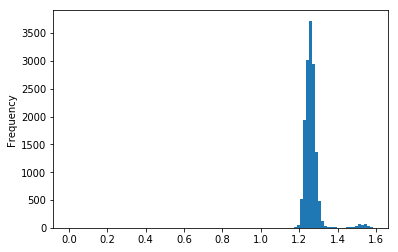

In [23]:
df_features.mean_diesel_short_timed.plot(kind='hist', bins=100)

In [24]:
# Drop all colums below threshold
df_features = df_features[df_features.mean_diesel_short_timed > 1.1]

In [25]:
x = df_features.relative_mean.values.reshape(-1, 1) #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_features['relative_mean_scaled'] = x_scaled

/Users/gabriel/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


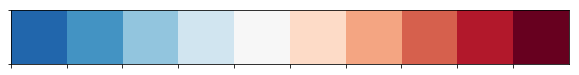

In [26]:
color_scale = ['#67001f','#b2182b','#d6604d','#f4a582','#fddbc7','#f7f7f7','#d1e5f0','#92c5de','#4393c3','#2166ac']
color_scale = np.flip(color_scale)
sns.palplot(sns.color_palette(color_scale))

In [27]:
cluster_map

NameError: name 'cluster_map' is not defined

In [28]:
top_20 = df_features.brand.value_counts()[0:30].index.to_list()
df_features.loc[df_features[~df_features.brand.isin(top_20)].index, 'brand'] = 'other'

/Users/gabriel/anaconda3/envs/nf/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [29]:
df_features.loc[df_features.brand.isin(list(df_features.brand.value_counts()[5:].index)), 'brand'] = 'other'

/Users/gabriel/anaconda3/envs/nf/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [30]:
df_features.brand.value_counts()

other    8697
aral     2276
shell    1743
esso     1012
total     842
Name: brand, dtype: int64

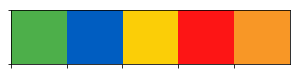

In [31]:
brand_colors = ['#4daf4a', '#005DC1', '#FBCE07','#FD1515', '#F89726']
sns.palplot(sns.color_palette(brand_colors))

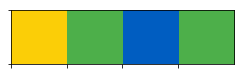

In [32]:
cluster_colors = ['#FBCE07', '#4daf4a', '#005DC1', '#4daf4a']
sns.palplot(sns.color_palette(cluster_colors))

In [33]:
def color_brand(row):
    if row == 'other':
        return brand_colors[0]
    elif row == 'aral':
        return brand_colors[1]
    elif row == 'shell':
        return brand_colors[2]
    elif row == 'esso':
        return brand_colors[3]
    elif row == 'total':
        return brand_colors[4]
    
df_features['color_brand'] = df_features.brand.apply(color_brand)

/Users/gabriel/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [34]:
def color_cluster(row):
    if row == 0:
        return cluster_colors[1]
    elif row == 1:
        return cluster_colors[0]
    elif row == 2:
        return cluster_colors[2]
    elif row == 3:
        return cluster_colors[3]
    
df_features['cluster_color'] = df_features.gmm_cluster.apply(color_cluster)

/Users/gabriel/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [44]:
df_features.

,changes_diesel,changes_e5,changes_e10,skewness_diesel,skewness_e5,skewness_e10,kurtosis_diesel,kurtosis_e5,kurtosis_e10,var_diesel,...,isAral,isShell,gmm_cluster,min_diesel_short_timed,max_diesel_short_timed,mean_diesel_short_timed,relative_mean,relative_mean_scaled,color_brand,cluster_color
00006210-0037-4444-8888-acdc00006210,4705.0,4803.0,4774.0,-1.817817,-3.146691,-3.072491,62.660141,61.539534,59.597531,0.004990,...,0,0,3,1.209,1.339,1.258110,-0.005177,0.321594,#4daf4a,#4daf4a
00016899-3247-4444-8888-acdc00000007,2871.0,2784.0,2788.0,1.714685,0.334382,0.333061,4.012224,-0.197960,-0.203483,0.003830,...,0,0,1,1.219,1.389,1.262609,-0.000678,0.330965,#4daf4a,#FBCE07
00041414-208c-4444-8888-acdc00000414,419.0,430.0,0.0,-6.888683,-6.175341,0.000000,58.131150,39.550679,-3.000000,0.020105,...,0,0,2,1.209,1.259,1.235829,-0.027457,0.275187,#4daf4a,#005DC1
00041450-0002-4444-8888-acdc00000002,180.0,176.0,181.0,1.835378,0.306207,-6.659782,2.587737,-0.672192,72.044662,0.004862,...,0,0,0,1.198,1.238,1.212286,-0.051001,0.226149,#4daf4a,#4daf4a
00047369-0001-4444-8888-acdc00000001,371.0,440.0,438.0,-8.004936,-5.534799,-5.514452,84.381312,33.474356,33.308699,0.014608,...,0,0,3,0.000,1.259,1.201707,-0.061579,0.204116,#4daf4a,#4daf4a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fff05f62-7e1e-42e4-8d71-6e2c9c963a8b,2834.0,2577.0,2577.0,0.440446,-0.013002,-0.013002,-0.270087,-1.283175,-1.283175,0.004661,...,0,0,0,1.519,1.549,1.530667,0.267380,0.889289,#F89726,#4daf4a
fff2435f-84de-4f41-b62b-9f6810169f45,1889.0,1985.0,0.0,0.861832,0.195566,0.000000,1.503967,-0.769527,-3.000000,0.002882,...,0,0,2,1.169,1.329,1.246097,-0.017190,0.296573,#4daf4a,#005DC1
fff261ef-ff00-4d2b-8669-ec2f7c57cd93,5486.0,5303.0,5303.0,0.922845,0.034749,0.034002,0.671088,-1.113226,-1.114091,0.003059,...,0,0,1,1.169,1.379,1.233844,-0.029442,0.271053,#4daf4a,#FBCE07
fffb0617-e77d-48dd-838c-f43a945f6f70,6723.0,6696.0,6696.0,0.987645,0.244564,0.244564,1.061596,-0.551191,-0.551191,0.003653,...,0,0,1,1.169,1.379,1.249486,-0.013801,0.303632,#4daf4a,#FBCE07


In [48]:
df_features['price_int'] = df_features.relative_mean_scaled**(1.5) * 20

/Users/gabriel/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [49]:
import folium

deutschland = [51.457323, 10.707835]

cluster_map = folium.Map(location = deutschland,
                 zoom_start = 6,
                 tiles = 'stamentoner'
                         #'cartodbdark_matter'
                        )

In [50]:
for index, row in df_features.iterrows():
    folium.CircleMarker(location = (row.latitude,
                                  row.longitude),
                        radius = row.price_int,
                        color = row.color_brand,
                        #fill = True,
                        #fill_color = row.cluster_color,
                        tooltip = row.brand
                        ).add_to(cluster_map)
    
    folium.CircleMarker(location = (row.latitude,
                                  row.longitude),
                        radius = 1,
                        color = row.cluster_color
                        ).add_to(cluster_map)

In [51]:
cluster_map.save('./plots/gas_station_cluster_2_layered_new.html')


# Take Aways
- Fuel on highways is expensive
- gas station density is low in the 'neue Bundesländer'
- mean prices for shell, esso, aral are more expensive than others
- very cheap gas stations are exclusively 'others'.
- gas stations in rural areas are generally cheaper
- Shell, Aral and others can be successfully clustered using gaussian mixture models!